This notebook is part of [miubrt](https://github.com/meteo-ubonn/miubrt).

Copyright (c) [miubrt developers](https://github.com/meteo-ubonn/miubrt/blob/main/CONTRIBUTORS.txt). 
Distributed under the MIT License. See [LICENSE.txt](https://github.com/meteo-ubonn/miubrt/blob/main/LICENSE.txt) for more info.

# Estimate specific and differential attenuation
<div class="alert alert-info">

**User Info** <br>
 Global Data - User Input 
   start_time, end_time, location, par, fil_create, thrnan, thrbin, fname_ppi, fname_ver
   location = "BoXPol" or "JuXPol"  (X-band radar)
   par contains multiple attributes which needs to be tuned
    
 PHIDP processing
    
 This is a research code!
   
</div>
 

In [110]:
import sys
import warnings
warnings.filterwarnings('ignore')

In [111]:
import wradlib
import datetime as dt
import numpy as np
import scipy
from scipy import stats
from scipy import signal
import dask
import wradlib as wrl
import xarray as xr
#

In [112]:
# for using local development version, uncomment next lines otherwise installed `miubrt` version will be used
miubrt_dir = "../../"
if sys.path[0] != miubrt_dir:
     sys.path.insert(0, "../../")

In [113]:
import miubrt as mrt

# Global Data - USER INPUT

In [114]:
start_time = dt.datetime(2015, 7, 5, 0, 0)
end_time   = dt.datetime(2015, 7, 5, 23, 59, 59)
location   = "BoXPol"
zh_offset  = -3.0 #[dbZ]
zdr_offset = -1.03 #[dB]
smoothlen  = 2000. #7000. # phidp scaling parameter for smoothing

#fname_ppi  = "/automount/cluma04/pshrestha/netcdf4/20150705/BoXPol_010_20150705_1400_1730.nc"
fname_ppi  = "/automount/cluma04/pshrestha/netcdf4/20150705/BoXPol_015_20150705_1400_1730.nc"
# User Input End #

# Load and Explore Dataset

In [115]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
from matplotlib import gridspec
from scipy.optimize import curve_fit
import hvplot
import hvplot.xarray
import holoviews as hv

## Load

In [116]:
swp = xr.open_dataset(fname_ppi,chunks={"time": 12})
swp = swp.pipe(wrl.georef.georeference_dataset)
swp  = swp.chunk()

## Calibrate Zh/Zdr

In [117]:
t = 20 #15
# Extract Zh, Zdr, RHOhv, PHIdp and VRADh for one time snapshot
zh    = swp.DBZH[t].load() - zh_offset
zdr   = swp.ZDR[t].load() - zdr_offset
rhohv = swp.RHOHV[t].load()
vradh = swp.VRADH[t]
# One need to load the xarray data if it is to be updated
phidp = swp.PHIDP[t].load()
print(swp.time[t].values)

2015-07-05T15:43:35.000000000


In [118]:
# Obtain range resolution [m] and dimensions of azimuth and range 
rangep = swp.range.load()
dr  = np.array((rangep[1] - rangep[0]))
na = swp.azimuth.size
nrange = swp.range.size

# Obtain initial estimates of Kdp, indexing in Python, [1:4] is [1:3]
kdps = np.empty([na, nrange])
kdps[:,1:nrange] =  phidp.diff("range")

kdps2 = np.empty([na, nrange])
kdps2[:,0:nrange-1] = phidp.diff("range")

# Find indices of undesirable PHIDP and set is as NaN
phidp1    = phidp.where(((vradh-zh)<2) & (rhohv > 0.87) & (kdps>-15) & 
                  (kdps<15) & (kdps2>-15) & (kdps2<15) & (zdr<5.5) &
                  (zdr>-6) & (zdr < (1.42 + 0.0661*zh**2 + 0.000485*zh**2)) &
                  (zh>5))

# Smoothing ratio
len1 = np.array(smoothlen/dr/2.)
len2 = np.array(len1/1.5)
len1 = len1.astype(int)
len2 = len2.astype(int)
print("Filter : " , smoothlen,len1, len2, dr)

#Calculuate rolling median (smoothlen) and box car average (3 gates)
nlen = len1*2
nlen = nlen.astype(int)
phidp2 = phidp1.rolling(range=nlen, center=True).median(skipna=True)
phidp3 = phidp2.rolling(range=3, center=True).mean(skipna=True)

# System offset estimate based on azimuth_median of range_median PHIDP values
phidp4 = phidp.where((phidp<3) & (zdr < 3) & (zdr>-3) & 
                  (rhohv>0.97))
phi0_range   = phidp4.median("range")
phi0 = np.nanmedian(phidp4)
# Get array of nan (0) and finite values (1)
phib   = xr.where(np.isnan(phidp4), 0, 1) 
nphib  = np.sum(phib) 
if (nphib != 0):
    print("Total data for system offset estimate: " ,nphib.values)
    print("System Offset = ", phi0)

    # Subtract system offset
    phidp5 = phidp3 - phi0
else:
    phidp5 = -92
    print("No PHI0 found")
    
#Remove clutter in the first 20 gates
phidp6 = np.empty([na, nrange])
phidp6[:,0:10] = xr.where(phidp5[:,0:10]>10,np.nan,phidp5[:,0:10])
phidp6[:,10:20] = xr.where(phidp5[:,10:20]>20,np.nan,phidp5[:,10:20])
phidp6[:,20:] = phidp5[:,20:]

####
az=270 #265
phidp6 = mrt.pol.phidp_filter(phidp6,rhohv,len1,len2,na,nrange,az)
###
# Remove below zero values
phidp6 = xr.where(phidp6 < 0, 0, phidp6)
print("Azimuth" ,swp.azimuth[az].values)

Filter :  2000.0 10 6 100.0
Total data for system offset estimate:  14955
System Offset =  -65.92172
Azimuth 270.5


[ 39 254 264 265 266 267 268 269 271 272 273 274 275 276 277 278 279 280
 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316
 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334]


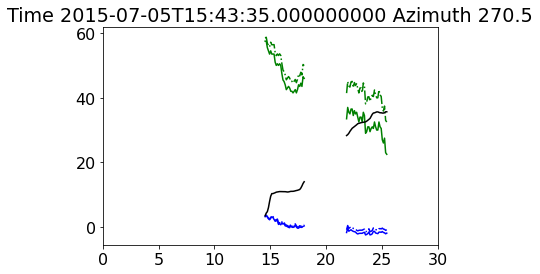

In [119]:
#Filter rays for computation with minimum 100 values
phib_nan   = xr.where(np.isnan(phidp6), 0, 1) 
zh    = xr.where(np.isnan(phidp6), np.nan, zh) 
zdr    = xr.where(np.isnan(phidp6), np.nan, zdr)
zh_corr = zh + 0.28* phidp6
zdr_corr = zdr + 0.03 * phidp6

phib_sum  = np.sum(phib_nan, axis=1)
ind_phidp = np.where(phib_sum > 100)[0]
print(ind_phidp)
az = 270 #ind_phidp[11] #265 #
rangekm = rangep/1000.
#plt.plot(rangekm, phidp_orig[az,:], '.', color='gray')
#plt.plot(rangekm, phidp[az,:], '-', color='red')
plt.plot(rangekm, zh[az,:], '-', color='green')
plt.plot(rangekm, zh_corr[az,:], '-.', color='green')
plt.plot(rangekm, zdr[az,:], '-', color='blue')
plt.plot(rangekm, zdr_corr[az,:], '-.', color='blue')
plt.plot(rangekm, phidp6[az,:], '-', color='black')
titstr = "Time " + str(swp.time[t].values) + " Azimuth " + str(swp.azimuth[az].values)
plt.title(titstr)

plt.xlim((0,30))
#plt.ylim((-90,-20))
plt.show()       